# LSTM-Supervised learning

Trial 10 Complete [00h 06m 31s]
val_accuracy: 0.9390073716640472

Best val_accuracy So Far: 0.9442894160747528
Total elapsed time: 00h 49m 24s
Epoch 1/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7518 - loss: 0.4804 - val_accuracy: 0.9165 - val_loss: 0.2018
Epoch 2/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8630 - loss: 0.2708 - val_accuracy: 0.9207 - val_loss: 0.1974
Epoch 3/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9172 - loss: 0.1944 - val_accuracy: 0.9314 - val_loss: 0.1733
Epoch 4/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9234 - loss: 0.1872 - val_accuracy: 0.9296 - val_loss: 0.1722
Epoch 5/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9238 - loss: 0.1799 - val_accuracy: 0.9320 - val_loss: 0.1716
Epoch 6/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9244 - loss: 0.1812 - val_accuracy: 0.9272 - val_loss: 0.1895
Epoch 7/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9275 - loss: 0.1774 - v

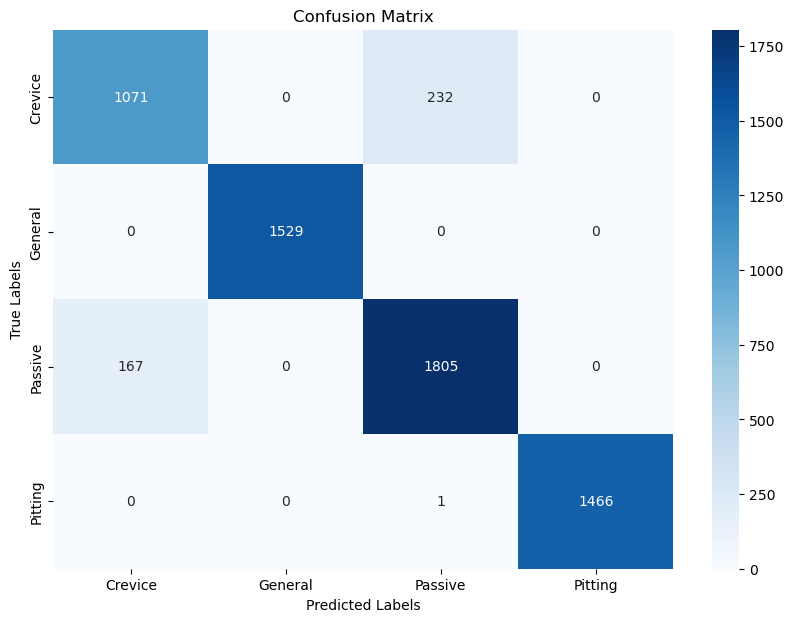

Best sequence length: 30
Best number of layers: 2
Best units for LSTM layer 1: 32
Best units for LSTM layer 2: 64


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
import seaborn as sns
import keras_tuner as kt

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences function
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

# Initial seq length
seq_length = 20
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Define the LSTM model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    # Tune the number of LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(
            units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
            activation='tanh',
            return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
            input_shape=(hp.Int('seq_length', 20, 100, step=10), X_train.shape[2]) if i == 0 else None
        ))

    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize Bayesian Optimization Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuning_dir',
    project_name='LSTM_tuning'
)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Predict on test data
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f'Best Model Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report:")
print(classification_report(y_test, y_test_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output the best hyperparameters found
print(f'Best sequence length: {best_hps.get("seq_length")}')
print(f'Best number of layers: {best_hps.get("num_layers")}')
for i in range(best_hps.get("num_layers")):
    print(f'Best units for LSTM layer {i+1}: {best_hps.get("units_" + str(i))}')


# Simple RNN-Supervised learning

Trial 10 Complete [00h 01m 31s]
val_accuracy: 0.950069785118103

Best val_accuracy So Far: 0.950069785118103
Total elapsed time: 00h 12m 37s
Best sequence length: 80
Best number of layers: 2
Best units for SimpleRNN layer 1: 96
Best units for SimpleRNN layer 2: 64
Epoch 1/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8196 - loss: 0.3688 - val_accuracy: 0.9123 - val_loss: 0.2835
Epoch 2/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8879 - loss: 0.2474 - val_accuracy: 0.8866 - val_loss: 0.2319
Epoch 3/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8705 - loss: 0.3110 - val_accuracy: 0.9199 - val_loss: 0.2021
Epoch 4/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9143 - loss: 0.2050 - val_accuracy: 0.9259 - val_loss: 0.1773
Epoch 5/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9149 - loss: 0.1998 - val_accuracy: 0.7929 - val_loss: 0.3354
Epoch 6/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8426 - loss: 0.3232 - val_acc

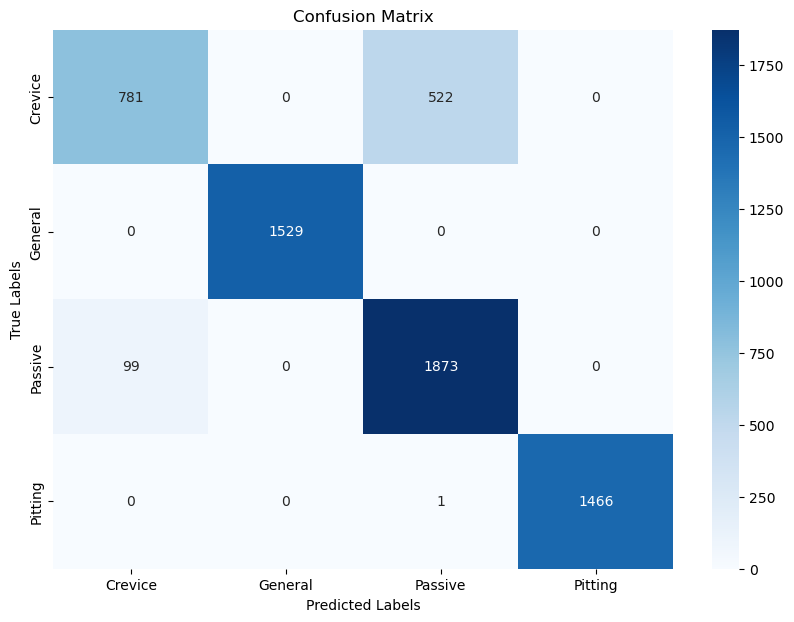

In [3]:
from tensorflow.keras.layers import SimpleRNN, Dense

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences function
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

# Define model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    # Tune the number of RNN layers and units
    for i in range(hp.Int('num_layers', 1, 3)):  # Up to 3 layers
        model.add(SimpleRNN(
            units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
            activation='tanh',
            return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,  # Only return sequences for layers before the last one
            input_shape=(hp.Int('seq_length', min_value=10, max_value=100, step=10), X_train.shape[2]) if i == 0 else None  # Sequence length as hyperparameter
        ))
    
    # Output layer
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the Keras Tuner for Bayesian Optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of models built for each trial (average result)
    directory='tuning_dir',
    project_name='SimpleRNN_tuning'
)

# Split the data into sequences
seq_length = 20  # Starting sequence length (this will be tuned)
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Run the tuner search to find the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_split=0.2)

# Get the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best sequence length and neuron count for each layer
print(f'Best sequence length: {best_hps.get("seq_length")}')
print(f'Best number of layers: {best_hps.get("num_layers")}')
for i in range(best_hps.get("num_layers")):
    print(f'Best units for SimpleRNN layer {i+1}: {best_hps.get("units_" + str(i))}')

# Build the best model with the tuned hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Predict on test data
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate classification performance
accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f'Best Model Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for SimpleRNN with Best Hyperparameters:")
print(classification_report(y_test, y_test_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# GRU-Supervised learning

Trial 10 Complete [00h 03m 51s]
val_accuracy: 0.9357185363769531

Best val_accuracy So Far: 0.9491727948188782
Total elapsed time: 00h 30m 01s
Best sequence length: 30
Best number of layers: 2
Best units for GRU layer 1: 128
Best units for GRU layer 2: 64
Epoch 1/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7713 - loss: 0.4321 - val_accuracy: 0.8954 - val_loss: 0.1947
Epoch 2/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9130 - loss: 0.1969 - val_accuracy: 0.9388 - val_loss: 0.1742
Epoch 3/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9189 - loss: 0.1928 - val_accuracy: 0.9326 - val_loss: 0.1837
Epoch 4/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9208 - loss: 0.1966 - val_accuracy: 0.9350 - val_loss: 0.1729
Epoch 5/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9178 - loss: 0.1944 - val_accuracy: 0.9310 - val_loss: 0.1724
Epoch 6/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9232 - loss: 0.1820 - val_accura

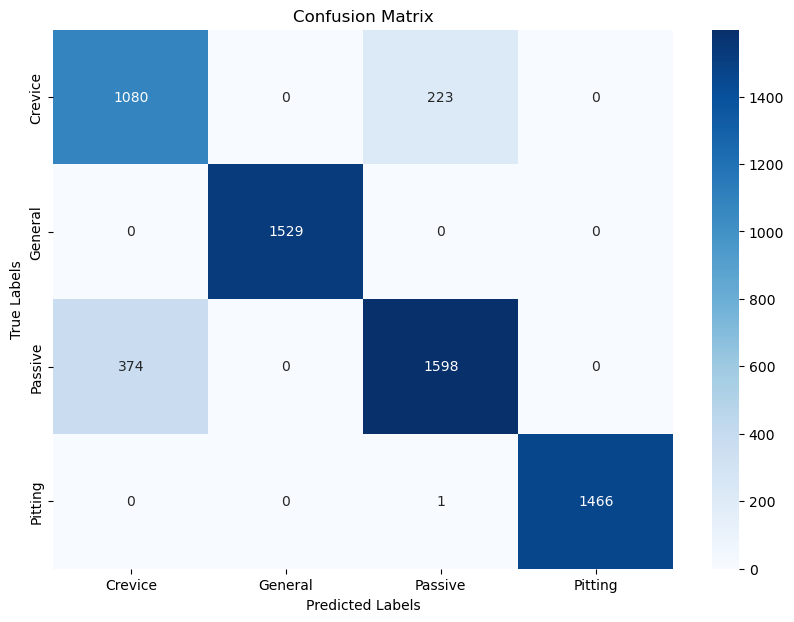

In [4]:
from tensorflow.keras.layers import GRU, Dense


# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences function
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

# Define model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    # Tune the number of GRU layers and units
    for i in range(hp.Int('num_layers', 1, 3)):  # Tune for 1 to 3 layers
        model.add(GRU(
            units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
            activation='tanh',
            return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,  # Return sequences for all layers except the last one
            input_shape=(hp.Int('seq_length', min_value=10, max_value=100, step=10), X_train.shape[2]) if i == 0 else None  # Sequence length as hyperparameter
        ))
    
    # Output layer
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the Keras Tuner for Bayesian Optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of models built for each trial (average result)
    directory='tuning_dir',
    project_name='GRU_tuning'
)

# Split the data into sequences
seq_length = 20  # Starting sequence length (this will be tuned)
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Run the tuner search to find the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_split=0.2)

# Get the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best sequence length and neuron count for each layer
print(f'Best sequence length: {best_hps.get("seq_length")}')
print(f'Best number of layers: {best_hps.get("num_layers")}')
for i in range(best_hps.get("num_layers")):
    print(f'Best units for GRU layer {i+1}: {best_hps.get("units_" + str(i))}')

# Build the best model with the tuned hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Predict on test data
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate classification performance
accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f'Best Model Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for GRU with Best Hyperparameters:")
print(classification_report(y_test, y_test_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
